In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch, torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


#### chatgpt

In [ ]:
# class NeuralNet(nn.Module):
#     def __init__(self):
#         super(NeuralNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 1x28×28
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(64 * 7 * 7, 128)
#         self.fc2 = nn.Linear(128, 10)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = self.pool(torch.relu(self.conv1(x)))
#         x = self.pool(torch.relu(self.conv2(x)))
#         x = x.view(-1, 64 * 7 * 7)
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# model = NeuralNet()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# for epoch in range(20):
#     running_loss = 0.0
#     for images, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(images.unsqueeze(1))
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         outputs = model(images.unsqueeze(1))
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [ ]:
# # Function to make predictions
# def predict_image(model, image):
#     image = image.unsqueeze(0).unsqueeze(0)
#     with torch.no_grad():
#         output = model(image)
#     return torch.argmax(output).item()

# # Display some predictions
# num_images = 5
# for i in range(num_images):
#     image, label = test_dataset[i]
#     plt.imshow(image.squeeze(), cmap='gray')
#     plt.title(f'Predicted: {predict_image(model, image)}')
#     plt.show()

# Load the CIFAR10 Datasets

In [ ]:
custom_transform = transforms.Compose([transforms.ToTensor()])

# resize, crop, flip(h/v), rotat
agumeted_transform = transforms.Compose([
    # transforms.RandomCrop(size=(32,32)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor()
])

In [ ]:
train_custom_data = datasets.CIFAR10(root="/content/datasets", train=True, download=True, transform=custom_transform)
test_custom_data = datasets.CIFAR10(root="/content/datasets", train=False, download=True, transform=custom_transform)

train_agu_data = datasets.CIFAR10(root="/content/datasets", train=True, download=True, transform=agumeted_transform)
test_agu_data = datasets.CIFAR10(root="/content/datasets", train=False, download=True, transform=agumeted_transform)

100%|██████████| 170M/170M [00:01<00:00, 96.9MB/s]


Extracting /content/datasets/cifar-10-python.tar.gz to /content/datasets
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# concat the both agumented and sample data
train_data = torch.utils.data.ConcatDataset([train_custom_data, train_agu_data])
test_data = torch.utils.data.ConcatDataset([test_custom_data, test_agu_data])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
sample1 = iter(train_loader)
img, label = next(sample1)

In [ ]:
img[0][0].shape

torch.Size([32, 32])

In [ ]:
def image_show(img):
    img_arr = img.numpy().transpose(1,2,0)
    plt.imshow(img_arr)
    plt.show()

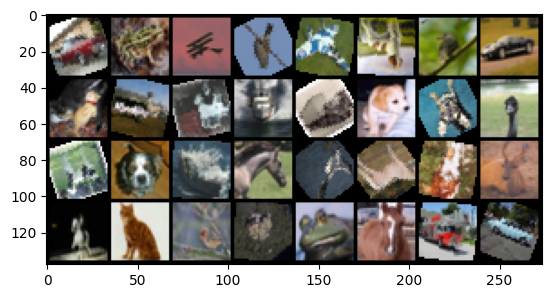

In [ ]:
image_show(torchvision.utils.make_grid(img))

In [ ]:
label

tensor([1, 6, 0, 2, 0, 5, 2, 1, 3, 0, 9, 8, 9, 5, 5, 2, 5, 5, 8, 7, 2, 7, 3, 4,
        7, 3, 2, 6, 6, 7, 9, 1])

In [ ]:
classes = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer',
           5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}

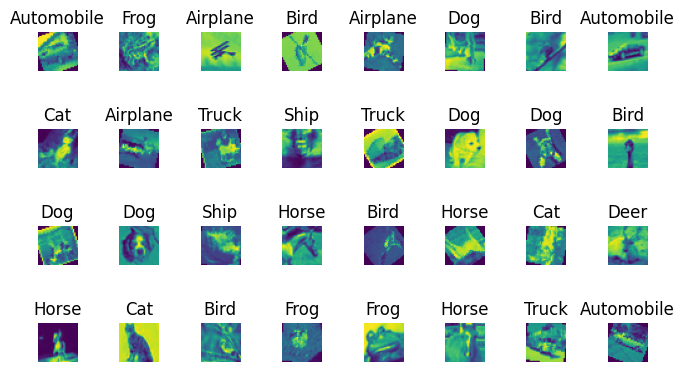

In [ ]:
for i in range(len(img)):
  plt.subplot(4, int(len(img)/4), i+1)
  plt.imshow(img[i][0])
  plt.title(classes[label[i].item()])
  plt.tight_layout()
  plt.axis('off')

# CNN Model Build

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0) # out = (32-5+0)/1+1 = 28*28
        self.pool = nn.MaxPool2d(2,2) # out = (28-2+0)/2+1 = 14*14
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0) # out = (14-5+0)/1+1 = 10*10
        # self.pool = nn.MaxPool2d(2,2) # out = (10-2+0)/2+1 = 5*5


        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.out = nn.Linear(84, 10)

    def forward(self, x):

        # i/p -> conv1 -> conv2 -> flatten layer -> fully connected -> o/p
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.out(x)

        return out

In [ ]:
model = CNN().to(device)

In [ ]:
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.01)

# Model Evaluation

In [ ]:
model.eval()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
correct = 0
total = 0

with torch.no_grad():

    for test_images, test_lables in test_loader:
        test_images, test_lables = test_images.to(device), test_lables.to(device)

        output = model(test_images)
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == test_lables).sum().item()
        total += test_lables.size(0) # batch_size=32

print(f"Model accuracy is: {correct/total*100:0.2f}%")

Model accuracy is: 56.75%


# CNN Model using Normalization Technique

In [ ]:
class CNNNormalize(nn.Module):
    def __init__(self):
        super(CNNNormalize, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1) # out = (32-3+2)/1+1 = 32*32
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=8, kernel_size=5, stride=1, padding=1) # out = (32-5+2)/1+1 = 30*30
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=10, kernel_size=3, stride=1, padding=1) # out = (30-3+2)/1+1 = 30*30
        self.conv4 = nn.Conv2d(in_channels=10, out_channels=12, kernel_size=5, stride=1, padding=0) # out = (30-5+0)/1+1 = 26*26
        self.dropout1 = nn.Dropout(0.1) # 10% switchOff the feeature
        self.dropout2 = nn.Dropout(0.2) # 20% switchOff the feeature

        self.fc1 = nn.Linear(12*26*26, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 50)
        self.out = nn.Linear(50, 10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = F.relu(self.fc3(x))
        x = self.dropout1(x)
        out = self.out(x)

        return out

In [ ]:
normallize_model = CNNNormalize().to(device)

In [ ]:
print(normallize_model)

CNNNormalize(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(10, 12, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=8112, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(normallize_model.parameters(), lr=0.001)

In [ ]:
for epoc in range(20):
    total_loss = 0

    for train_iamges, train_lables in train_loader:
        train_images, train_lables = train_iamges.to(device), train_lables.to(device)

        optimizer.zero_grad()
        output = normallize_model(train_images)
        loss = criterion(output, train_lables)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"for Epoch: {epoc+1}/20, the Total Loss is: {total_loss}")

for Epoch: 1/20, the Total Loss is: 7205.503809452057
for Epoch: 2/20, the Total Loss is: 7200.073969841003
for Epoch: 3/20, the Total Loss is: 7197.444795370102
for Epoch: 4/20, the Total Loss is: 7196.106998682022
for Epoch: 5/20, the Total Loss is: 7195.258070230484
for Epoch: 6/20, the Total Loss is: 7194.2936182022095


KeyboardInterrupt: 

In [ ]:
normallize_model.eval()

correct = 0
total = 0

with torch.no_grad():

    for test_images, test_lables in test_loader:
        test_images, test_lables = test_images.to(device), test_lables.to(device)

        output = normallize_model(test_images)
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == test_lables).sum().item()
        total += test_lables.size(0) # batch_size=32

print(f"Model accuracy is: {correct/total*100:0.2f}%")